In [4]:
import IPython.display as display
from PIL import Image
import os
import pathlib
import tensorflow as tf

In [27]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
print("TensorFlow Version: {}".format(tf.__version__))

TensorFlow Version: 2.1.0


In [40]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [8]:
image_dir = "/Users/thibaultdesfontaines/data/leaf-classification/new_images"
image_dir = pathlib.Path(image_dir)

In [31]:
CLASS_NAMES = [x for x in sorted(os.listdir(str(image_dir))) if x[0] != '.']
CLASS_NAMES = np.array(CLASS_NAMES)
print("Number of classes: {}".format(len(CLASS_NAMES)))

Number of classes: 99


In [10]:
sample_class = "Quercus_Trojana"
class_dir = os.path.join(image_dir, sample_class)
items = list(os.listdir(class_dir))

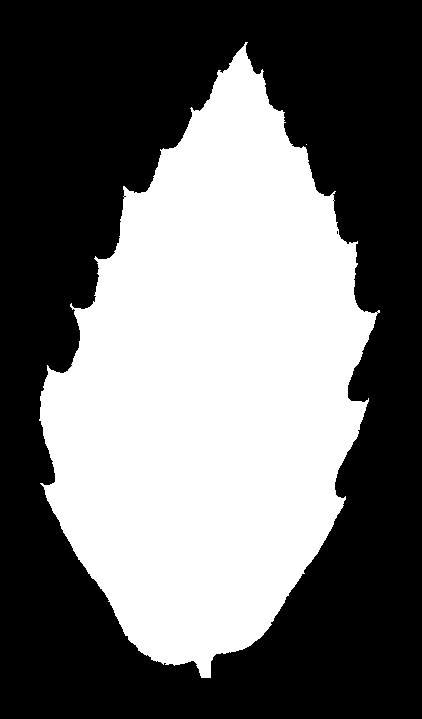

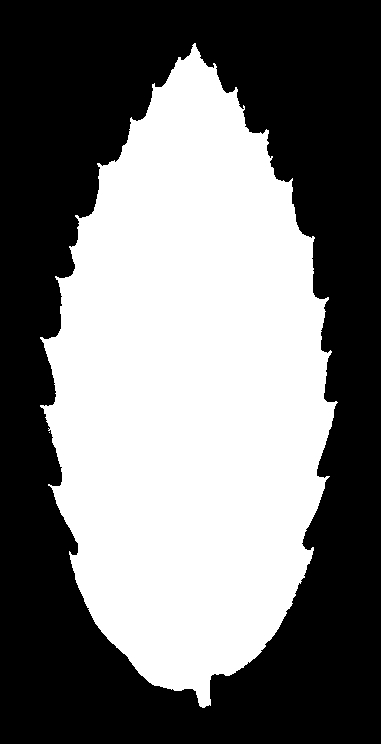

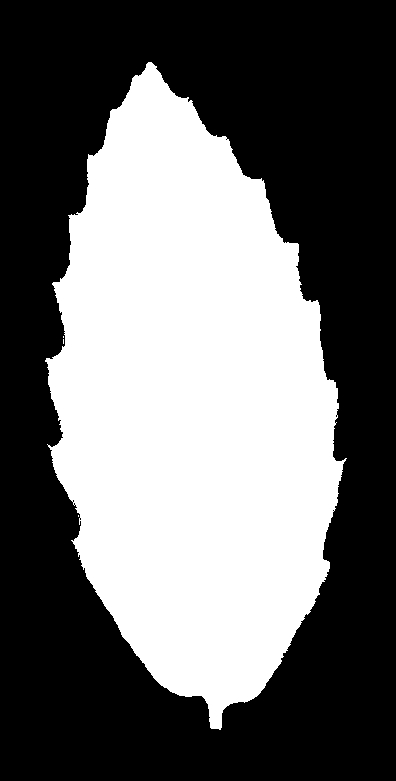

In [11]:
for image_path in items[:3]:
    display.display(Image.open(os.path.join(class_dir, image_path)))

In [18]:
im = Image.open(os.path.join(class_dir, image_path))

In [19]:
im.size

(396, 781)

In [16]:
image_count = 0
for class_ in [x for x in os.listdir(image_dir) if x[0]!='.']:
    for image_ in os.listdir(os.path.join(image_dir, class_)):
        image_count += 1

In [17]:
print("Image count:", image_count)

Image count: 990


In [20]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [23]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [24]:
train_data_gen = image_generator.flow_from_directory(
        directory=str(image_dir),
        batch_size=BATCH_SIZE,
        shuffle=True,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        classes = list(CLASS_NAMES))

Found 990 images belonging to 99 classes.


In [25]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

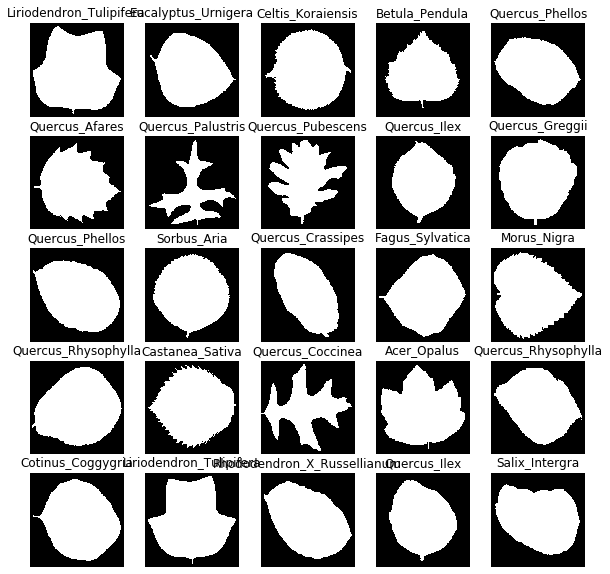

In [32]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [33]:
list_ds = tf.data.Dataset.list_files(str(image_dir/'*/*'))

In [35]:
for f in list_ds.take(5):
    print(f.numpy())

b'/Users/thibaultdesfontaines/data/leaf-classification/new_images/Zelkova_Serrata/1443.jpg'
b'/Users/thibaultdesfontaines/data/leaf-classification/new_images/Ilex_Cornuta/1347.jpg'
b'/Users/thibaultdesfontaines/data/leaf-classification/new_images/Quercus_Palustris/1446.jpg'
b'/Users/thibaultdesfontaines/data/leaf-classification/new_images/Phildelphus/673.jpg'
b'/Users/thibaultdesfontaines/data/leaf-classification/new_images/Cornus_Macrophylla/467.jpg'


In [36]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES

In [37]:
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [38]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [41]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [42]:
for image, label in labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]


In [43]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [44]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

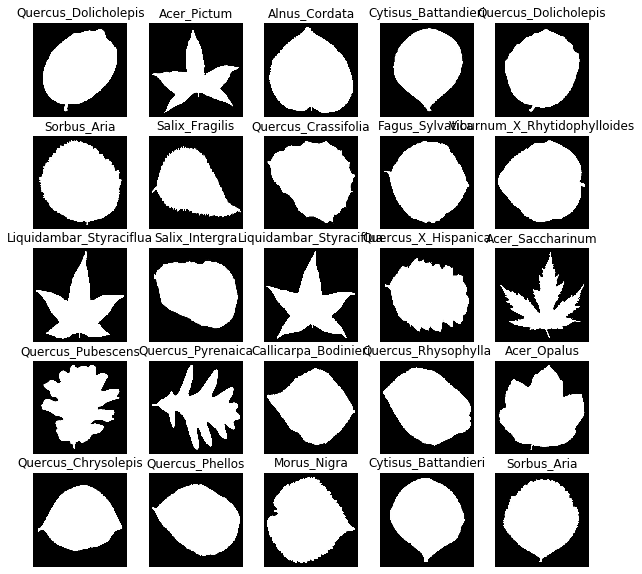

In [45]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [46]:
import time
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))

In [47]:
# `keras.preprocessing`
timeit(train_data_gen)

....................................................................................................
1000 batches: 53.18196702003479 s
601.70772 Images/s


In [48]:
timeit(train_ds)

....................................................................................................
1000 batches: 3.9059410095214844 s
8192.64805 Images/s


In [49]:
uncached_ds = prepare_for_training(labeled_ds, cache=False)
timeit(uncached_ds)

....................................................................................................
1000 batches: 48.22503089904785 s
663.55582 Images/s


In [50]:
filecache_ds = prepare_for_training(labeled_ds, cache="./flowers.tfcache")
timeit(filecache_ds)

....................................................................................................
1000 batches: 29.480551958084106 s
1085.46136 Images/s
